# Think Bayes: Chapter 2

This notebook presents example code and exercise solutions for Think Bayes.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.display import display
from sympy import symbols
import matplotlib.pyplot as plt
import mythinkbayes as mtb
import numpy as np
import pandas as pd

'Done'

'Done'

## The Pmf class

I'll start by making a Pmf that represents the outcome of a six-sided die.  Initially there are 6 values with equal probability.

In [2]:
dice = mtb.DiscreteVariable(range(1, 7), priors=[1/6] * 6)
dice

1    0.166667
2    0.166667
3    0.166667
4    0.166667
5    0.166667
6    0.166667
dtype: float64

To be true probabilities, they have to add up to 1.  So we can normalize the Pmf:

In [3]:
dice = mtb.DiscreteVariable(range(1, 7), priors=[1] * 6)
dice.normalize()
dice, dice.sum()

(1    0.166667
 2    0.166667
 3    0.166667
 4    0.166667
 5    0.166667
 6    0.166667
 dtype: float64, 0.9999999999999999)

You can copy the variable and add new values, but you need to remember to re-nnormalize.

In [4]:
tmp =  dice.copy()
tmp[7] = tmp[6]
tmp.normalize()

1    0.142857
2    0.142857
3    0.142857
4    0.142857
5    0.142857
6    0.142857
7    0.142857
dtype: float64

Or you can use the bracket operator.  ~~Either way, if you ask for the probability of something that's not in the Pmf, the result is 0.~~

In [5]:
dice[1]

0.16666666666666666

## The cookie problem

Here's a Pmf that represents the prior distribution.

In [6]:
cookies = mtb.DiscreteVariable(['Bowl 1', 'Bowl 2'])
cookies

Bowl 1    0.5
Bowl 2    0.5
dtype: float64

And we can update it using `Mult`

In [7]:
# Say we draw a vanilla cookie from the bowl. We represent this by
# multiplying each bowl's prior by the probability of drawing a vanilla
# cookie from it. We then see that the probability of Bowl 1 given we
# drew a vanilla cookie increases to 0.6.
cookies['Bowl 1'] *= 0.75
cookies['Bowl 2'] *= 0.5
cookies.normalize()

Bowl 1    0.6
Bowl 2    0.4
dtype: float64

Draw a few more vanilla cookies to see how the probabilities change.

In [8]:
cookies = mtb.DiscreteVariable(['Bowl 1', 'Bowl 2'])
cookies.normalize()

for i in range(5):
    cookies['Bowl 1'] *= 0.75
    cookies['Bowl 2'] *= 0.5
    cookies.normalize()
    display('Draw vanilla %d' % (i + 1), cookies)

'Draw vanilla 1'

Bowl 1    0.6
Bowl 2    0.4
dtype: float64

'Draw vanilla 2'

Bowl 1    0.692308
Bowl 2    0.307692
dtype: float64

'Draw vanilla 3'

Bowl 1    0.771429
Bowl 2    0.228571
dtype: float64

'Draw vanilla 4'

Bowl 1    0.835052
Bowl 2    0.164948
dtype: float64

'Draw vanilla 5'

Bowl 1    0.883636
Bowl 2    0.116364
dtype: float64

## The Bayesian framework

Here's the same computation encapsulated in a class.

We can confirm that we get the same result.

In [9]:
class CookieExample(mtb.DiscreteVariable):
    """Wrapper class for the cookie example. Same operations as the
    previous example, but the priors are contained within the class."""
    
    # Dictionary defining P(D | H), the probability of each cookie (data) 
    # given each bowl (hyptothesis). Structured such that P(D|H) = likelihoods[H][D].
    likelihoods = {
        'Bowl 1': dict(vanilla=0.75, chocolate=0.25),
        'Bowl 2': dict(vanilla=0.5, chocolate=0.5)
    }
    
    def update(self, D):
        """Update each hypothess' probability based on data.
        
        When update() gets called, self represents the prior P(H) (or equivalently,
        the posterior of a previous update).
        
        To compute the posterior given the observed data D, each P(H) gets
        multiplied by likelihood P(D | H), as in the RHS numerator of Bayes theorem.
        
        To get the posterior P(H | D), one must normalize by P(D). Assuming
        that the hypotheses in self are mutually exclusive and collectively
        exhaustive, it suffices to call self.normalize().
        
        In the end, self represents the posterior given the observed data, D.
        """
        for H in self.index.values:
            self[H] *= self.likelihoods[H][D]
        return self.normalize()
    
cookies = CookieExample(['Bowl 1', 'Bowl 2'])

for i in range(5):
    display(i + 1, cookies.update('vanilla'))

1

Bowl 1    0.6
Bowl 2    0.4
dtype: float64

2

Bowl 1    0.692308
Bowl 2    0.307692
dtype: float64

3

Bowl 1    0.771429
Bowl 2    0.228571
dtype: float64

4

Bowl 1    0.835052
Bowl 2    0.164948
dtype: float64

5

Bowl 1    0.883636
Bowl 2    0.116364
dtype: float64

But this implementation is more general; it can handle any sequence of data.

In [10]:
cookies = CookieExample(['Bowl 1', 'Bowl 2'])
for data in ['vanilla', 'vanilla', 'chocolate', 'vanilla']:
    cookies.update(data)
cookies

Bowl 1    0.627907
Bowl 2    0.372093
dtype: float64

## The Monty Hall problem

The Monty Hall problem might be the most contentious question in
the history of probability.  The scenario is simple, but the correct
answer is so counterintuitive that many people just can't accept
it, and many smart people have embarrassed themselves not just by
getting it wrong but by arguing the wrong side, aggressively,
in public.

Monty Hall was the original host of the game show *Let's Make a
Deal*.  The Monty Hall problem is based on one of the regular
games on the show.  If you are on the show, here's what happens:

*  Monty shows you three closed doors and tells you that there is a
   prize behind each door: one prize is a car, the other two are less
   valuable prizes like peanut butter and fake finger nails.  The
   prizes are arranged at random.

*  The object of the game is to guess which door has the car.  If
   you guess right, you get to keep the car.

*  You pick a door, which we will call Door A.  We'll call the
   other doors B and C.

*  Before opening the door you chose, Monty increases the
   suspense by opening either Door B or C, whichever does not
   have the car.  (If the car is actually behind Door A, Monty can
   safely open B or C, so he chooses one at random.)

*  Then Monty offers you the option to stick with your original
   choice or switch to the one remaining unopened door.

The question is, should you "stick" or "switch" or does it
make no difference?

Most people have the strong intuition that it makes no difference.
There are two doors left, they reason, so the chance that the car
is behind Door A is 50%.

But that is wrong.  In fact, the chance of winning if you stick
with Door A is only 1/3; if you switch, your chances are 2/3.

Here's a class that solves the Monty Hall problem.

In [11]:
class MontyExample(mtb.DiscreteVariable):
    
    def pick_door(self, D):
        """Pick a door for the prize."""
        self.picked = D
    
    def open_door(self, D):
        """Update the posterior for a specific door, D, having been opened by the host."""
        
        for H in self.index.values:
                
            # This hypothesis represents the door that was just opened,
            # so there's no chance the prize is behind this door.
            if H == D:
                self[H] *= 0
                
            # This hypothesis represents the door previously picked
            # and is not the door that was just opened. So there is
            # now a 50/50 chance of this being the correct door.
            elif H == self.picked:
                self[H] *= 0.5
                
            # Otherwise, the hypothesis' probability stays the same.
            else:
                pass
                
        return self.normalize()


# Initialize with uniform prior on each door.
monty = MontyExample(['Door A', 'Door B', 'Door C'])
display(monty)

# You pick door A.
monty.pick_door('Door A')

# Then the host opens door B.
monty.open_door('Door B')

# What's the resulting posterior?
monty

Door A    0.333333
Door B    0.333333
Door C    0.333333
dtype: float64

Door A    0.333333
Door B    0.000000
Door C    0.666667
dtype: float64

## The Suite class

Most Bayesian updates look pretty much the same, especially the `Update` method.  So we can encapsulate the framework in a class, `Suite`, and create new classes that extend it.

Child classes of `Suite` inherit `Update` and provide `Likelihood`.  So here's the short version of `Monty`

I just extened the `DiscreteVariable` class to contain an `update` method.

In [12]:
class MontyExample(mtb.DiscreteVariable):
    
    def pick_door(self, data):
        self.picked = data
        
    def open_door(self, data):
        return self.update(data)
    
    def likelihood(self, data, hypo):
        if hypo == data:
            return 0
        if hypo == self.picked:
            return 0.5
        return 1
    
monty = MontyExample(['Door A', 'Door B', 'Door C'])
monty.pick_door('Door A')
monty.open_door('Door B')
monty

Door A    0.333333
Door B    0.000000
Door C    0.666667
dtype: float64

## The M&M problem

M&Ms are small candy-coated chocolates that come in a variety of
colors.  Mars, Inc., which makes M&Ms, changes the mixture of
colors from time to time.

In 1995, they introduced blue M&Ms.  Before then, the color mix in
a bag of plain M&Ms was 30% Brown, 20% Yellow, 20% Red, 10%
Green, 10% Orange, 10% Tan.  Afterward it was 24% Blue , 20%
Green, 16% Orange, 14% Yellow, 13% Red, 13% Brown.

Suppose a friend of mine has two bags of M&Ms, and he tells me
that one is from 1994 and one from 1996.  He won't tell me which is
which, but he gives me one M&M from each bag.  One is yellow and
one is green.  What is the probability that the yellow one came
from the 1994 bag?

Here's a solution:

In [13]:
class MMExperiment(mtb.DiscreteVariable):
  
    # Define P(color, year) for each year.
    mix94 = dict(brown=30,
                 yellow=20,
                 red=20,
                 green=10,
                 orange=10,
                 tan=10,
                 blue=0)

    mix96 = dict(blue=24,
                 green=20,
                 orange=16,
                 yellow=14,
                 red=13,
                 brown=13,
                 tan=0)
    
    # Define likelihoods for two hypotheses: A and B:
    # A: bag 1 is from 1994, bag 2 from 1996.
    # B: bag 1 is from 1996, bag 1 from 1994.
    likes=dict(
        A=dict(bag1=mix94, bag2=mix96),
        B=dict(bag1=mix96, bag2=mix94))
    
    
    def likelihood(self, data, hypo):
        """Compute, return the likelihood P(D | H)."""
        bag, color = data
        return self.likes[hypo][bag][color]

mm = MMExperiment(['A', 'B'])

# You get a yellow M&M from bag 1 and a green from bag 2.
mm.update(('bag1', 'yellow'))
mm.update(('bag2', 'green'))

mm

A    0.740741
B    0.259259
dtype: float64

**Exercise:**  Suppose you draw another M&M from `bag1` and it's blue.  What can you conclude?  Run the update to confirm your intuition.

In [14]:
# Blue M&M's were introduced in 1996, so bag1 = 1994 is impossible.
# Thus Hypothesis A is impossible.
mm.update(('bag1', 'blue'))

A    0.0
B    1.0
dtype: float64

**Exercise:**  Now suppose you draw an M&M from `bag2` and it's blue.  What does that mean?  Run the update to see what happens.

In [15]:
# Again, it's only possible for a blue to come from the 1996 bag.
# Thus, Hypothesis B is impossible. If you run this after the previous cell,
# you get NaNs, because it's impossible to have drawn a blue from both bags.
mm.update(('bag2', 'blue'))

A   NaN
B   NaN
dtype: float64

## Exercises

**Exercise:** This one is from one of my favorite books, David MacKay's "Information Theory, Inference, and Learning Algorithms":

> Elvis Presley had a twin brother who died at birth.  What is the probability that Elvis was an identical twin?"
    
To answer this one, you need some background information: According to the Wikipedia article on twins:  ``Twins are estimated to be approximately 1.9% of the world population, with monozygotic twins making up 0.2% of the total---and 8% of all twins.''

In [16]:
# Start with priors: P(fraternal) = 0.92, P(identical) = 0.08
elvis = mtb.DiscreteVariable(['fraternal', 'identical'], [0.92, 0.08])
display(elvis)

# The question states that Elvis had a twin **brother**.
# Update the priors using the likelihoods:
# P(brother | fraternal) = 0.5
# P(brother | identical) = 1
elvis['fraternal'] *= 0.5
elvis['identical'] *= 1
display(elvis)

# Normalize to get the posteriors P(fraternal | brother), P(identical | brother).
# Fraternal becomes slightly less likely and identical slightly more likely.
elvis.normalize()

fraternal    0.92
identical    0.08
dtype: float64

fraternal    0.46
identical    0.08
dtype: float64

fraternal    0.851852
identical    0.148148
dtype: float64

**Exercise:** Let's consider a more general version of the Monty Hall problem where Monty is more unpredictable.  As before, Monty never opens the door you chose (let's call it A) and never opens the door with the prize.  So if you choose the door with the prize, Monty has to decide which door to open.  Suppose he opens B with probability `p` and C with probability `1-p`.  If you choose A and Monty opens B, what is the probability that the car is behind A, in terms of `p`?  What if Monty opens C?

Hint: you might want to use SymPy to do the algebra for you. 

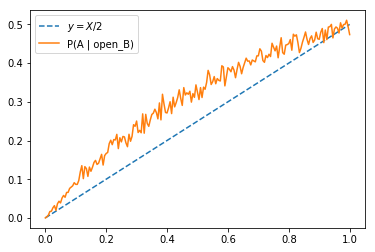

In [17]:
# Simulate the described sequence.
# Plot it against a naive linear model.

def simulate(p=0.8, door_chosen='A', door_interest='B', nb_iter=2000):
    
    nb_wins = 0
    nb_matched = 0

    for _ in range(nb_iter):

        # Select the prize door at random.
        door_prize = np.random.choice(['A', 'B', 'C'])

        # Two ways to open the door of interest:
        # 1. You picked the winning door and Monty opens door of interest with probability p.
        if door_chosen == door_prize and np.random.binomial(1, p):
            nb_wins += 1
            nb_matched += 1
            
        # 2: the prize is behind the third door and Monty has to open the door of interest.
        elif door_prize != door_chosen and door_prize != door_interest:
            nb_matched += 1
        
    return nb_wins / nb_matched
    
X = np.linspace(0, 1, 201)
Y = list(map(simulate, X))

plt.plot(X, X / 2, label='$y=X / 2$', linestyle='--')
plt.plot(X, Y, label='P(A | open_B)')
plt.legend()
plt.show()

A    0.333333
B    0.333333
C    0.333333
dtype: float64

P(A | open_B) = 0.333333333333333*p/(0.333333333333333*p + 0.333333333333333)


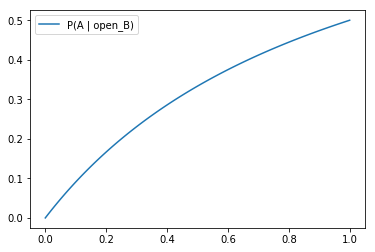

In [18]:
# Solution for when Monty has opened door B.
# Plot P(A | open_B) for various values of p.
# Notice this matches the above plot nicely.

# Initialize with uniform prior on each door.
# Where A, B, and C are shorthand for "Prize at A", "Prize at B", and "Prize at C."
monty = mtb.DiscreteVariable(['A', 'B', 'C'])
display(monty)

# Define symbolic p, the probability of opening B.
p = symbols('p')

# Monty has opened door B. Update the priors below, with some
# comments on the logic for each update.

# Update P(A | open_B) = P(A) * P(open_B | A) / P(open_B).
# P(open_B | A) is the value p that was given (or symbolicly defined).
monty['A'] *= p

# Update P(B | open_B) = P(B) * P(open_B | B) / P(open_B).
# Since Monty never opens the door with the prize, P(open_B | B) = 0. 
monty['B'] *= 0

# Update P(C | open_B) = P(C) * P(open_B | C) / P(open_B).
# You picked A and monty opened B. Monty never opens the door you picked and
# never opens the door with the prize. If the prize is at C, Monty must open_B.
# Thus, P(open_B | C) = 1.
monty['C'] *= 1

# Normalize.
monty.normalize()

monty['A'].simplify()

print('P(A | open_B) = %s' % monty['A'])

# Plot the results for various values of p.
X = np.linspace(0, 1, 101)
Y = [monty['A'].evalf(subs={p:x}) for x in X]

plt.plot(X, Y, label='P(A | open_B)')
plt.legend()
plt.show()

A    0.333333
B    0.333333
C    0.333333
dtype: float64

P(A | open_C) = (-0.333333333333333*p + 0.333333333333333)/(-0.333333333333333*p + 0.666666666666667)


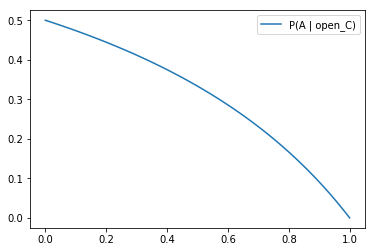

In [19]:
# Repeat the same for when Monty has opened C.

# Initialize with uniform prior on each door.
# Where A, B, and C are shorthand for "Prize at A", "Prize at B", and "Prize at C."
monty = mtb.DiscreteVariable(['A', 'B', 'C'])
display(monty)

# Define symbolic p, the probability of opening B.
p = symbols('p')

# Monty has opened door C. Update the priors below, with some
# comments on the logic for each update.

# Update P(A | open_C) = P(A) * P(open_C | A) / P(open_C).
# P(open_C | A) is the value 1 - p that was given (or symbolicly defined).
monty['A'] *= 1 - p

# Update P(B | open_C) = P(B) * P(open_C | B) / P(open_C).
# You picked A and monty opened C. Monty never opens the door you picked and
# never opens the door with the prize. If the prize is at B, Monty must open C.
# Thus, P(open_C | B) = 1.
monty['B'] *= 1

# Update P(C | open_C) = P(C) * P(open_C | C) / P(open_C).
# Since Monty never opens the door with the prize, P(open_C | C) = 0. 
monty['C'] *= 0

# Normalize.
monty.normalize()

monty['A'].simplify()

print('P(A | open_C) = %s' % monty['A'])

# Plot the results for various values of p.
X = np.linspace(0, 1, 101)
Y = [monty['A'].evalf(subs={p:x}) for x in X]

plt.plot(X, Y, label='P(A | open_C)')
plt.legend()
plt.show()


**Exercise:** According to the CDC, 

> Compared to nonsmokers, men who smoke are about 23 times more likely to develop lung cancer and women who smoke are about 13 times more likely.

Also, among adults in the U.S. in 2014:

> Nearly 19 of every 100 adult men (18.8%) are smokers.

> Nearly 15 of every 100 adult women (14.8%) are smokers.

If you learn that a woman has been diagnosed with lung cancer, and you know nothing else about her, what is the probability that she is a smoker?

In [20]:
# 2 methods, both end up with p(smoker | cancer) ~= 0.7.

# Method 1: use a symbol 'b' to represent the baseline probability for a non-smoking woman getting cancer.
# Compute p(smoker | cancer) = p(smoker) * p(cancer | smoker) / p(cancer).

b = symbols('b') # The baseline probability that a woman gets cancer.

ex = mtb.DiscreteVariable(['S','N'], [0.15, 0.85])
ex['S'] *= 13 * b
ex['N'] *= 1 * b
display(ex.normalize())

# Method 2: use relative likelihoods.
ex = mtb.DiscreteVariable(['S', 'N'], [0.15, 0.85])
ex['S'] *= 13
ex['N'] *= 1
display(ex.normalize())

S    0.696428571428571
N    0.303571428571429
dtype: object

S    0.696429
N    0.303571
dtype: float64

**Exercise** In Section 2.3 I said that the solution to the cookie problem generalizes to the case where we draw multiple cookies with replacement.

But in the more likely scenario where we eat the cookies we draw, the likelihood of each draw depends on the previous draws.

Modify the solution in this chapter to handle selection without replacement. Hint: add instance variables to Cookie to represent the hypothetical state of the bowls, and modify Likelihood accordingly. You might want to define a Bowl object.

In [21]:
class CookieExample(mtb.DiscreteVariable):
    """Wrapper class for the cookie example."""
    
    # Dictionary defining P(D | H), the probability of each cookie (data) 
    # given each bowl (hyptothesis). Structured such that P(D|H) = likelihoods[H][D].
    # Assume we start with 100 cookies in each bowl.
    likelihoods = {
        'Bowl 1': dict(vanilla=75, chocolate=25),
        'Bowl 2': dict(vanilla=50, chocolate=50)
    }
    
    def update(self, D):
        """Update each hypothess' probability based on data.
        
        When update() gets called, self represents the prior P(H) (or equivalently,
        the posterior of a previous update).
        
        To compute the posterior given the observed data D, each P(H) gets
        multiplied by likelihood P(D | H), as in the RHS numerator of Bayes theorem.
        
        To get the posterior P(H | D), one must normalize by P(D). Assuming
        that the hypotheses in self are mutually exclusive and collectively
        exhaustive, it suffices to call self.normalize().
        
        In the end, self represents the posterior given the observed data, D.
        """
        
        # Multiply each prior by its corresponding likelihood.
        # Decrement the count corresponding to the cookie that was picked.
        for H in self.index.values:
            self[H] *= self.likelihoods[H][D]
            self.likelihoods[H][D] -= 1
        
        return self.normalize()
    
cookies = CookieExample(['Bowl 1', 'Bowl 2'])

for data in ['vanilla', 'chocolate']:
    display('Pick %s' % data, cookies.update(data))

'Pick vanilla'

Bowl 1    0.6
Bowl 2    0.4
dtype: float64

'Pick chocolate'

Bowl 1    0.428571
Bowl 2    0.571429
dtype: float64